In [1]:
import arsenal_gear as ag
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from time import time

Initialize a basic stellar population that uses Isochrone-based interpolation and a discrete representation of the underlying stellar population

In [2]:
pop1_dict = {"Mtot": 1e5 * u.Msun, "imf": "kroupa", "seed": 42}
pop2_dict = {"Mtot": 1e5 * u.Msun, "imf": "chabrier", "seed": 42}

sp = ag.SynthPop(interp_op="iso", pop1=pop1_dict, pop2=pop2_dict)

In [8]:
sp.evol.se

AttributeError: 'Evolution' object has no attribute 'se'

By default `arsenal_gear` sets up a discrete population of single stars, we can access the details of this population as:

In [3]:
pop = sp.form.subpops[0]
print(pop)

SinglePop(Mtot=<Quantity 100000. solMass>, Nstar=226404, metallicity=<Quantity 0.>, imf=<arsenal_gear.formation.dist_funcs.imf.Kroupa object at 0x31736e5f0>, mmin=<Quantity 0.08 solMass>, mmax=<Quantity 100. solMass>, discrete=True, masses=<Quantity [0.17079782, 1.2908727 , 0.43362736, ..., 1.10077221, 0.15365925,
           1.62878141] solMass>)


Check the distribution of masses in comparison to the underlying PDF from which it is sampled.

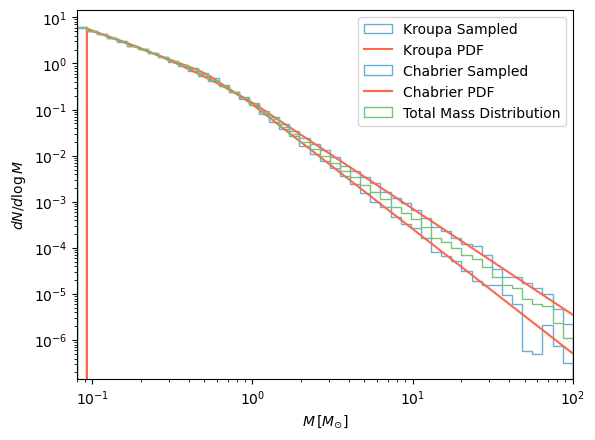

In [4]:
for pop in sp.form.subpops:
    mbins = np.logspace(np.log10(pop.imf.min_mass), np.log10(pop.imf.max_mass), 50)

    plt.hist(pop.masses.value, bins=mbins,density=True,histtype='step',color=plt.cm.Blues(0.5),label=f"{pop.imf.name} Sampled")
    plt.plot(mbins, pop.imf._pdf(mbins), color=plt.cm.Reds(0.5), label=f"{pop.imf.name} PDF")

plt.hist(sp.masses.value, bins=mbins,density=True,histtype='step',color=plt.cm.Greens(0.5),label="Total Mass Distribution")

plt.yscale("log")
plt.xscale("log")
plt.xlim(pop.imf.min_mass, pop.imf.max_mass)
plt.xlabel(r"$M \, [M_{\odot}]$")
plt.ylabel(r"$dN/d\log M$")
plt.legend()

Plot the specifc SN rate for the population at a sample of different times

In [9]:
tlin = np.logspace(6,8,100)*u.yr
plt.plot(tlin, sp.ndotsn(tlin)/sp.form.Mtot.to(u.Msun), label="Cumulative SNe")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$t$ [yr]")
plt.ylabel(r"$\dot{\mathcal{N}}_{\rm SN} \, [M_{\odot}^{-1}\, {\rm Myr}^{-1}]$")
plt.xlim(1e6,1e8)
plt.ylim(1e-5,8e-4)

AttributeError: 'Evolution' object has no attribute 'se'

Construct the isochrone for the population, first for each star in the discrete population, and then the underlying isochrone that is created to interpolate the isochrone to. Output timing for each calculation to give an idea of how long these things take. The `sp.evol.se.construct_isochrone()` function call also interpolates quantites like `log_g`, `log_R`, and surface abundances.

Isochrone interpolation time: 0.7567 s
Isochrone construction time: 0.9467 s


(-2.0, 6.0)

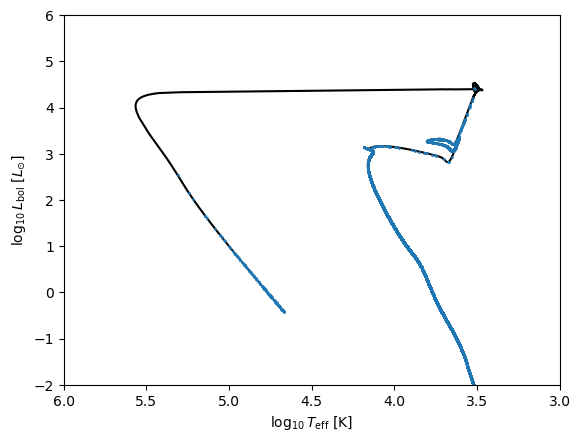

In [9]:
t = np.array([100])*u.Myr
timing = -1*time()
Lbol = sp.lbol_iso(t, pop)
Teff = sp.teff_iso(t, pop)
timing += time()
print(f"Isochrone interpolation time: {timing:.4f} s")

timing = -1*time()
iso = sp.evol.se.construct_isochrone(t)
timing += time()
print(f"Isochrone construction time: {timing:.4f} s")
plt.plot(np.log10(iso.teff.value), np.log10(iso.lbol.value),'k-')
plt.plot(np.log10(Teff.value), np.log10(Lbol.value), 'o',ms=1)

plt.xlabel(r"$\log_{10} T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L_{\rm bol}$ [$L_{\odot}$]")
plt.xlim(6,3)
plt.ylim(-2,6)

Take a look at the surface abundances of the elements as a function of their initial mass.

(1e-05, 1)

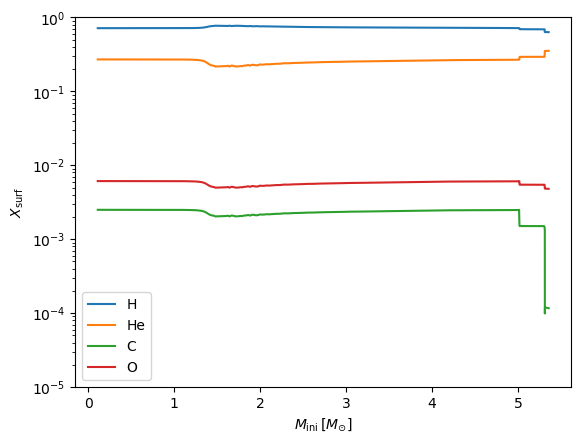

In [10]:
for (i,elem) in enumerate(iso.elems):
    plt.plot(iso.mini, iso.qs[iso.elems[i]], label=elem)

plt.legend()
plt.xlabel(r"$M_{\rm ini} \, [M_{\odot}]$")
plt.ylabel(r"$X_{\rm surf}$")
plt.yscale("log")
plt.ylim(1e-5,1)

Investigate the history of the bolometric luminosity of the population as a function of time. This should take about 30 seconds to calculate.

In [13]:
lbol_hist = sp.lbol(tlin)
teff_hist = sp.teff(tlin)

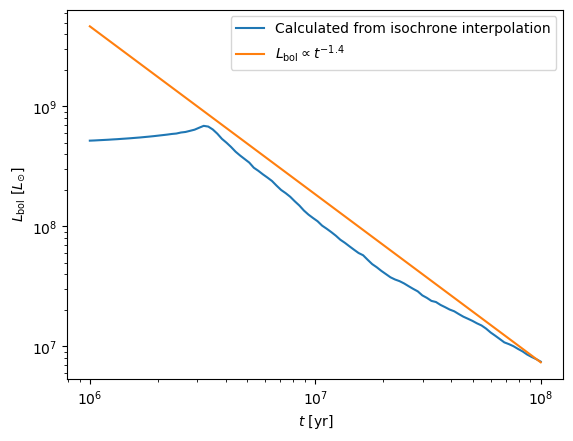

In [12]:
plt.plot(tlin.value, lbol_hist.value, label="Calculated from isochrone interpolation")
plt.plot(tlin.value, 1e9*(tlin.value/3e6)**-1.4, label=r"$L_{\rm bol} \propto t^{-1.4}$")

plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$L_{\rm bol}$ [$L_{\odot}$]")
plt.xlabel(r"$t$ [yr]")
plt.legend()